# HSMM

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import ssm
from ssm.util import rle, find_permutation

In [2]:
npr.seed(0)

# Set the parameters of the HMM
T = 5000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of observed dimensions


In [5]:
ssm.HSMM?

Init signature:
ssm.HSMM(
    K,
    D,
    *,
    M=0,
    init_state_distn=None,
    transitions='nb',
    transition_kwargs=None,
    observations='gaussian',
    observation_kwargs=None,
    **kwargs,
)
Docstring:     
Hidden semi-Markov model with non-geometric duration distributions.
The trick is to expand the state space with "super states" and "sub states"
that effectively count duration. We rely on the transition model to
specify a "state map," which maps the super states (1, .., K) to
super+sub states ((1,1), ..., (1,r_1), ..., (K,1), ..., (K,r_K)).
Here, r_k denotes the number of sub-states of state k.
File:           ~/WORK/CurrentWork_codes/HMM/SSM/ssm/hmm.py
Type:           type
Subclasses:     


In [6]:
# Make an HMM with the true parameters
true_hsmm = ssm.HSMM(K, D, observations="gaussian")
true_hsmm.transitions.rs
z, y = true_hsmm.sample(T)
z_test, y_test = true_hsmm.sample(T)
true_ll = true_hsmm.log_probability(y)

/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [7]:
true_hsmm.transitions.rs

array([ 1,  2, 10,  1, 11])

In [9]:
y_test.shape

(5000, 2)

In [11]:
# Fit an HSMM
N_em_iters = 100


In [12]:

print("Fitting Gaussian HSMM with EM")
hsmm = ssm.HSMM(K, D, observations="gaussian")
hsmm_em_lls = hsmm.fit(y, method="em", num_iters=N_em_iters)


Fitting Gaussian HSMM with EM


/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [13]:

print("Fitting Gaussian HMM with EM")
hmm = ssm.HMM(K, D, observations="gaussian")
hmm_em_lls = hmm.fit(y, method="em", num_iters=N_em_iters)


Fitting Gaussian HMM with EM


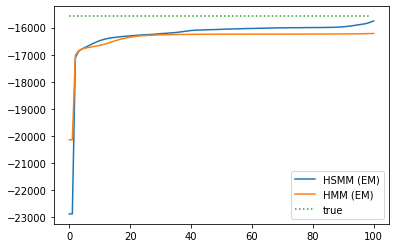

In [14]:
# Plot log likelihoods (fit model is typically better)
plt.figure()
plt.plot(hsmm_em_lls, ls='-', label="HSMM (EM)")
plt.plot(hmm_em_lls, ls='-', label="HMM (EM)")
plt.plot(true_ll * np.ones(N_em_iters), ':', label="true")
plt.legend(loc="lower right")

In [15]:
# Print the test likelihoods (true model is typically better)
print("Test log likelihood")
print("True HSMM: ", true_hsmm.log_likelihood(y_test))
print("Fit HSMM:  ", hsmm.log_likelihood(y_test))
print("Fit HMM: ", hmm.log_likelihood(y_test))

Test log likelihood
True HSMM:  -15690.43835253103
Fit HSMM:   -15877.25122952925
Fit HMM:  -16411.876217652174


/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [16]:
# Plot the true and inferred states
hsmm.permute(find_permutation(z, hsmm.most_likely_states(y)))
hsmm_z = hsmm.most_likely_states(y)
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
hmm_z = hsmm.most_likely_states(y)

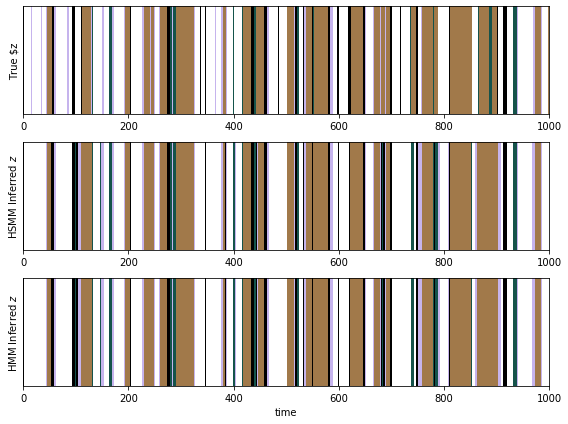

In [17]:
# Plot the true and inferred discrete states
plt.figure(figsize=(8, 6))
plt.subplot(311)
plt.imshow(z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K-1)
plt.xlim(0, 1000)
plt.ylabel("True $z")
plt.yticks([])

plt.subplot(312)
plt.imshow(hsmm_z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K-1)
plt.xlim(0, 1000)
plt.ylabel("HSMM Inferred $z$")
plt.yticks([])

plt.subplot(313)
plt.imshow(hmm_z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K-1)
plt.xlim(0, 1000)
plt.ylabel("HMM Inferred $z$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

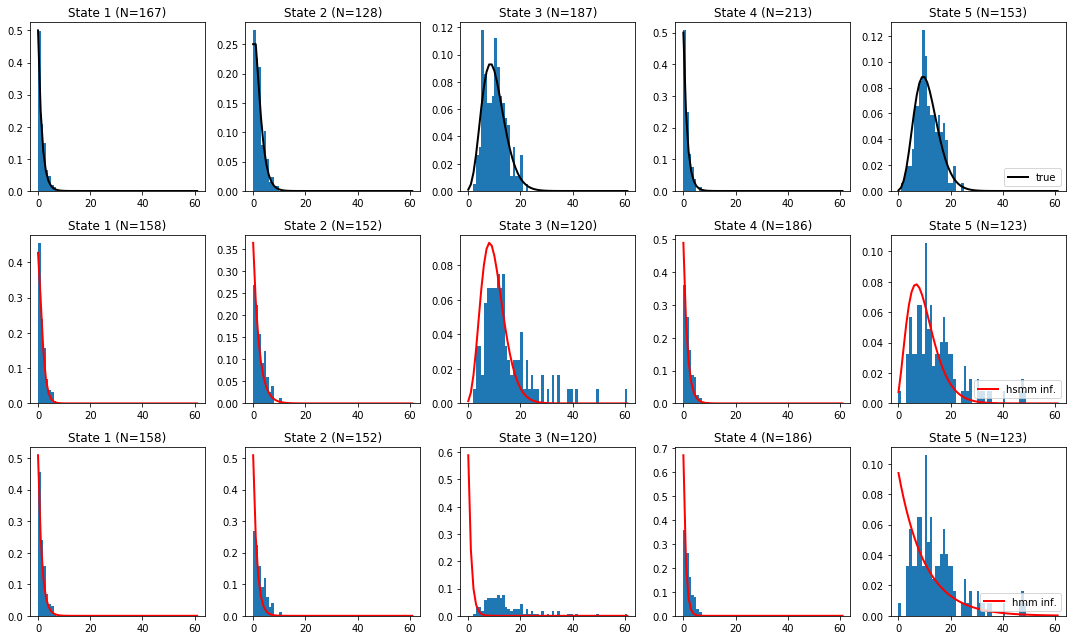

In [18]:

# Plot the true and inferred duration distributions
states, durations = rle(z)
inf_states, inf_durations = rle(hsmm_z)
hmm_inf_states, hmm_inf_durations = rle(hsmm_z)
max_duration = max(np.max(durations), np.max(inf_durations), np.max(hmm_inf_durations))
dd = np.arange(max_duration, step=1)

plt.figure(figsize=(3 * K, 9))
for k in range(K):
    # Plot the durations of the true states
    plt.subplot(3, K, k+1)
    plt.hist(durations[states == k] - 1, dd, density=True)
    plt.plot(dd, nbinom.pmf(dd, true_hsmm.transitions.rs[k], 1 - true_hsmm.transitions.ps[k]),
             '-k', lw=2, label='true')
    if k == K - 1:
        plt.legend(loc="lower right")
    plt.title("State {} (N={})".format(k+1, np.sum(states == k)))

    # Plot the durations of the inferred states
    plt.subplot(3, K, K+k+1)
    plt.hist(inf_durations[inf_states == k] - 1, dd, density=True)
    plt.plot(dd, nbinom.pmf(dd, hsmm.transitions.rs[k], 1 - hsmm.transitions.ps[k]),
             '-r', lw=2, label='hsmm inf.')
    if k == K - 1:
        plt.legend(loc="lower right")
    plt.title("State {} (N={})".format(k+1, np.sum(inf_states == k)))

        # Plot the durations of the inferred states
    plt.subplot(3, K, 2*K+k+1)
    plt.hist(hmm_inf_durations[hmm_inf_states == k] - 1, dd, density=True)
    plt.plot(dd, nbinom.pmf(dd, 1, 1 - hmm.transitions.transition_matrix[k, k]),
             '-r', lw=2, label='hmm inf.')
    if k == K - 1:
        plt.legend(loc="lower right")
    plt.title("State {} (N={})".format(k+1, np.sum(inf_states == k)))
plt.tight_layout()

plt.show()
